<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/Siamese_Network/blob/main/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 7.6 MB/s 
     |████████████████████████████████| 376 kB 60.4 MB/s 
     |████████████████████████████████| 58 kB 6.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=013831687f144d08ff3f624d0286c6dd276c8ce590eda6aef72294c430181bf9
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=823b843f79848c90695ae490943d5d4455da59f7b4e721b0d74710bdf630cabb
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 15.44 MiB/s, done.


In [30]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [31]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm

In [32]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_PATH = '/content/Person-Re-Id-Dataset/train.csv'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15
DEVICE = 'cuda'

In [33]:
df = pd.read_csv(CSV_PATH)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [34]:
row = df.iloc[4]
A = io.imread(DATA_DIR + row.Anchor)
N = io.imread(DATA_DIR + row.Negative)
P = io.imread(DATA_DIR + row.Positive)


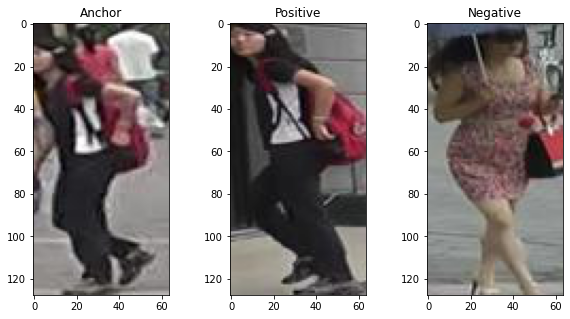

In [35]:

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
ax1.set_title('Anchor')
ax1.imshow(A)
ax2.set_title('Positive')
ax2.imshow(P)
ax3.set_title('Negative')
ax3.imshow(N)

In [36]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [37]:
class SN_DS(Dataset):
  
  def __init__(self, df):
    self.df =df
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = df.iloc[idx]
    A = io.imread(DATA_DIR + row.Anchor)
    A = torch.from_numpy(A).permute(2, 0, 1)/255.0
    N = io.imread(DATA_DIR + row.Negative)
    N = torch.from_numpy(N).permute(2, 0, 1)/255.0
    P = io.imread(DATA_DIR + row.Positive)
    P = torch.from_numpy(P).permute(2, 0, 1)/255.0

    return A, P, N


In [38]:
trainset = SN_DS(train_df)
valset = SN_DS(val_df)

In [39]:
len(trainset), len(valset)

(3200, 800)

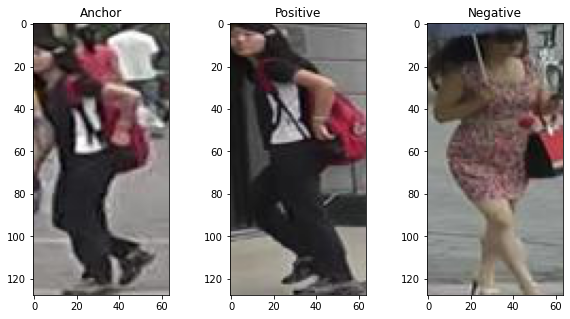

In [40]:
A, P, N = trainset[4]
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose(1,2,0), cmap='gray')
ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose(1,2,0), cmap='gray')
ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose(1,2,0), cmap='gray')

In [41]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader  = DataLoader(valset, batch_size=BATCH_SIZE)
len(trainloader), len(valloader)

(100, 25)

In [42]:
class SN_Model(nn.Module):
  def __init__(self, emb_size=512):
    super(SN_Model, self).__init__()
    self.net = timm.create_model('efficientnet_b0', pretrained=True)
    self.net.classifier = nn.Linear(in_features= self.net.classifier.in_features, out_features= emb_size)

  def forward(self, img):
    embs = self.net(img)
    return embs


In [43]:
model = SN_Model()
model.to(DEVICE)

SN_Model(
  (net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, tra

In [44]:
def train_func(model, dataloader, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
    
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)
    
    loss = criterion(A_embs, P_embs, N_embs)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
  
  return total_loss/ len(dataloader) 



def eval_func(model, dataloader, criterion):
  model.eval()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
    
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)
    
    loss = criterion(A_embs, P_embs, N_embs)
    
    total_loss += loss.item()
  
  return total_loss/ len(dataloader) 

In [46]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [48]:
best_val_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_func( model, trainloader, optimizer, criterion)
  val_loss = eval_func(model, valloader, criterion)

  if val_loss < best_val_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model saved!")
    best_val_loss = val_loss

  print(f"Epoch={i+1}, train_loss= {train_loss}, val_loss={val_loss}")

100%|██████████| 25/25 [00:02<00:00,  8.65it/s]


Model saved!
Epoch=1, train_loss= 0.024693590551614762, val_loss=0.017858686447143553


100%|██████████| 25/25 [00:02<00:00,  8.80it/s]


Epoch=2, train_loss= 0.045674496740102766, val_loss=0.02799384295940399


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Model saved!
Epoch=3, train_loss= 0.03552353039383888, val_loss=0.009422927498817443


100%|██████████| 25/25 [00:02<00:00,  8.78it/s]


Epoch=4, train_loss= 0.03985093109309673, val_loss=0.032772398591041564


100%|██████████| 25/25 [00:02<00:00,  8.68it/s]


Epoch=5, train_loss= 0.022143230363726615, val_loss=0.019337124824523926


100%|██████████| 25/25 [00:02<00:00,  9.21it/s]


Epoch=6, train_loss= 0.0336951419711113, val_loss=0.032046418786048886


100%|██████████| 25/25 [00:02<00:00,  8.88it/s]


Epoch=7, train_loss= 0.04043690398335457, val_loss=0.03506148159503937


100%|██████████| 25/25 [00:02<00:00,  8.97it/s]


Epoch=8, train_loss= 0.03964068785309791, val_loss=0.03365273535251617


100%|██████████| 25/25 [00:04<00:00,  5.52it/s]


Epoch=9, train_loss= 0.021326348334550858, val_loss=0.010325403809547424


100%|██████████| 25/25 [00:04<00:00,  5.57it/s]


Epoch=10, train_loss= 0.019057326912879945, val_loss=0.015425187945365905


100%|██████████| 25/25 [00:05<00:00,  4.75it/s]


Model saved!
Epoch=11, train_loss= 0.03352378837764263, val_loss=0.006315390467643738


100%|██████████| 25/25 [00:02<00:00,  8.84it/s]


Epoch=12, train_loss= 0.019670958817005157, val_loss=0.013341320753097534


100%|██████████| 25/25 [00:02<00:00,  8.79it/s]


Model saved!
Epoch=13, train_loss= 0.031141502261161805, val_loss=0.005638830065727234


100%|██████████| 25/25 [00:02<00:00,  8.71it/s]


Epoch=14, train_loss= 0.014069279134273529, val_loss=0.01016362190246582


100%|██████████| 25/25 [00:02<00:00,  8.93it/s]

Epoch=15, train_loss= 0.01309687152504921, val_loss=0.010471583604812621


In [54]:
#Get Anchor embeddings:
def get_anchor_embs(model, anch_imgs):
  anch_imgs_arr = np.array(anch_imgs)
  embs = []

  model.eval()
  for i in tqdm(anch_imgs_arr):
    A = io.imread(DATA_DIR + i)
    A = torch.from_numpy(A).permute(2, 0, 1)/255.0
    A = A.to(DEVICE)
    A_emb = model(A.unsqueeze(0))
    embs.append(A_emb.squeeze().cpu().detach().numpy())
  
  embs = np.array(embs)
  embs = pd.DataFrame(embs)
  df_embs = pd.concat([anch_imgs, embs], axis=1)

  return df_embs



In [55]:
model.load_state_dict(torch.load('/content/best_model.pt'))
df_embs = get_anchor_embs(model, df['Anchor'])

100%|██████████| 4000/4000 [01:09<00:00, 57.96it/s]


In [56]:
df_embs.to_csv('database.csv', index=False)
df_embs.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.322341,-0.559677,-0.109899,-1.112306,0.375416,-0.016491,-0.186802,0.544188,0.016737,...,0.188651,0.129330,0.180955,0.492610,0.333801,0.928443,-0.418511,-0.573266,0.312183,0.218712
1,1420_c3s3_061978_03.jpg,-0.232824,-0.897527,-0.027869,-0.880991,0.171742,-0.044551,-0.300122,0.788558,0.356130,...,0.541770,0.821345,0.357335,0.383106,0.714252,0.620638,0.142204,-0.681891,0.661351,-0.296691
2,1420_c5s3_062565_05.jpg,-0.157428,-0.739824,-0.104446,-1.144671,0.355951,-0.088424,0.052309,0.640859,0.116758,...,0.414415,0.576464,0.338701,0.478930,0.689800,0.864726,-0.081517,-0.631054,0.586756,-0.185004
3,1420_c6s3_085592_04.jpg,-0.411767,-0.758370,-0.041032,-0.719222,0.029317,0.018180,-0.458651,0.822650,0.159560,...,0.477279,0.409747,0.208842,0.366691,0.407855,0.697288,0.052402,-0.446552,0.606349,-0.065653
4,0663_c5s3_085987_03.jpg,-0.601159,0.349780,0.375359,0.549853,-0.096701,-0.123249,-0.753088,-0.522139,0.665545,...,-0.120089,-1.019636,-0.065159,-0.325154,-0.496359,-0.975819,-0.093030,0.202251,-0.915964,0.098013


In [57]:
#Inference:

def euclidean_distance(test_img_emb, database_emb):
  return np.sqrt(np.dot(test_img_emb - database_emb, (test_img_emb - database_emb).T))

In [58]:
idx = 0
img_name = df_embs['Anchor'].iloc[idx]
A = io.imread(DATA_DIR + img_name)
A = torch.from_numpy(A).permute(2, 0, 1)/255.0
A = A.to(DEVICE)

model.eval()
img_emb = model(A.unsqueeze(0))
img_emb = img_emb.detach().cpu().numpy()


In [59]:
db_embs_arr = df_embs.iloc[:,1:].to_numpy()
db_img_names = df_embs['Anchor']

In [61]:
distances = []

for i in range(db_embs_arr.shape[0]):
  dist = euclidean_distance(img_emb, db_embs_arr[i : i+1, :])
  distances = np.append(distances, dist)

In [62]:
closest_idx = np.argsort(distances)

/usr/local/lib/python3.7/dist-packages/networkx/drawing/layout.py:727: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


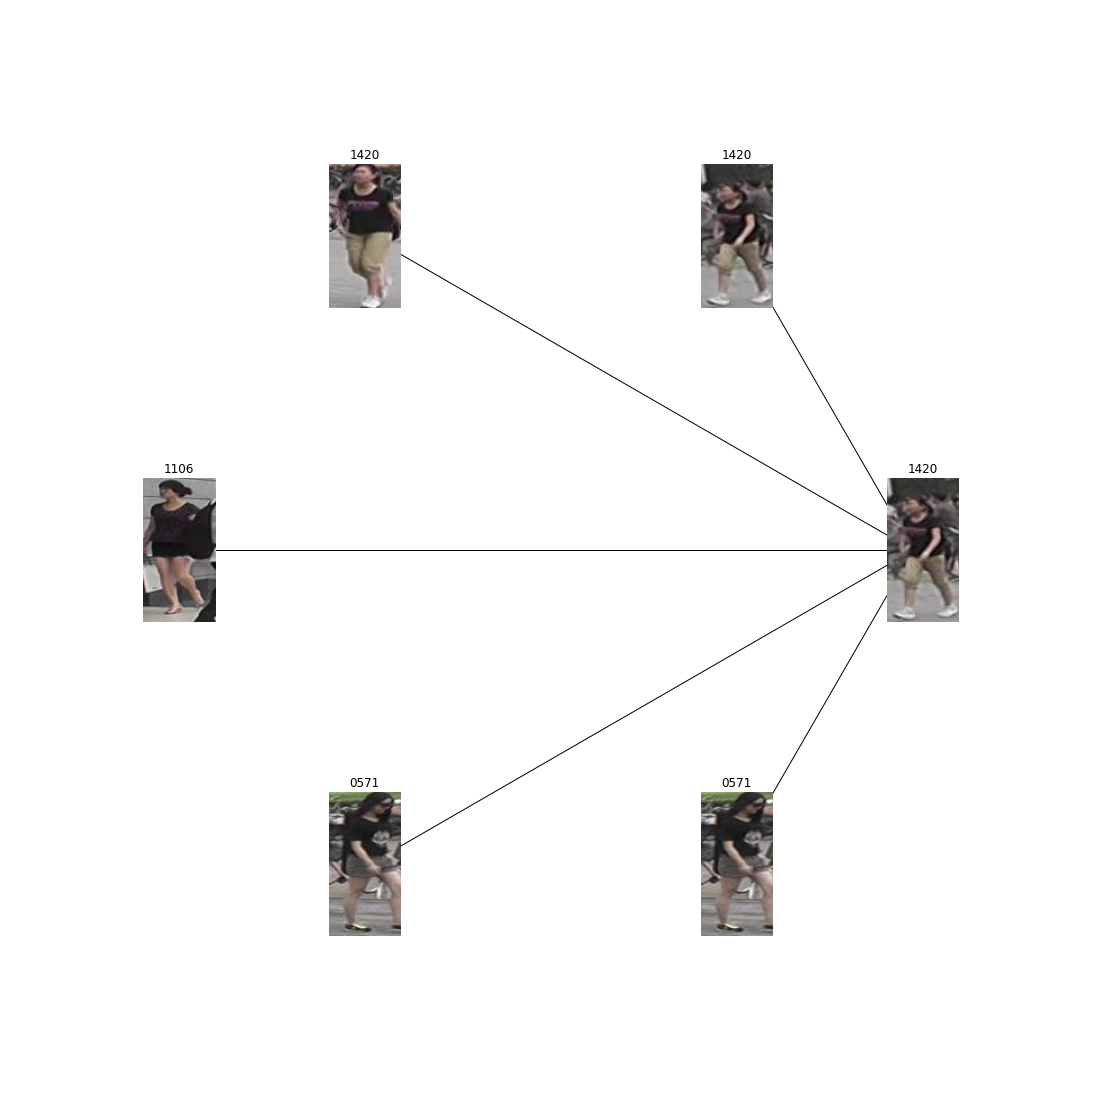

In [63]:
from utils import plot_closest_imgs

plot_closest_imgs(db_img_names, DATA_DIR, img_name, (DATA_DIR + img_name), closest_idx, distances, no_of_closest=5)